In [ ]:
!pip install kaggle

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from pylab import imread,subplot,imshow,show
import cv2
import os


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign -p /content

Dataset URL: https://www.kaggle.com/datasets/fanconic/skin-cancer-malignant-vs-benign
License(s): unknown
skin-cancer-malignant-vs-benign.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
with zipfile.ZipFile("/content/skin-cancer-malignant-vs-benign.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/data")

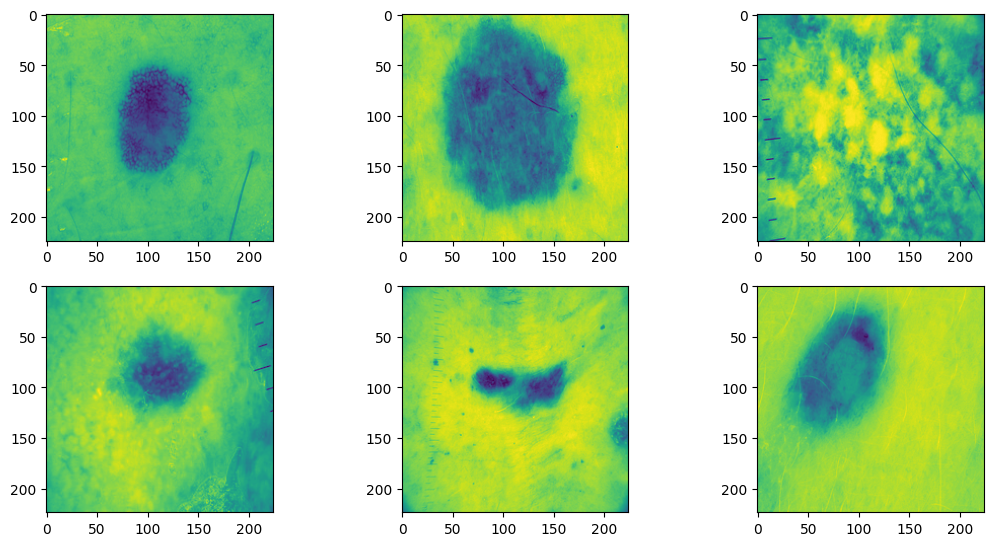

In [ ]:
fig = plt.figure(figsize=(13, 10))

path = r'data/train/benign/100.jpg'
Image1 = cv2.imread(path,0)

path_1 = r'data/train/benign/1021.jpg'
Image2 = cv2.imread(path_1,0)

path_2 = r'data/train/malignant/19.jpg'
Image3 = cv2.imread(path_2,0)

path_3 = r'data/train/malignant/55.jpg'
Image4 = cv2.imread(path_3,0)

path_4 = r'data/test/benign/105.jpg'
Image5 = cv2.imread(path_4,0)

path_5 = r'data/test/benign/259.jpg'
Image6 = cv2.imread(path_5,0)

fig.add_subplot(3,3,1)
plt.imshow(Image1)
fig.add_subplot(3,3,2)
plt.imshow(Image2)
fig.add_subplot(3,3,3)
plt.imshow(Image3)
fig.add_subplot(3,3,4)
plt.imshow(Image4)
fig.add_subplot(3,3,5)
plt.imshow(Image5)
fig.add_subplot(3,3,6)
plt.imshow(Image6)


In [ ]:
train = ImageDataGenerator(rescale=1./255)
test =  ImageDataGenerator(rescale=1./255)
val =  ImageDataGenerator(rescale=1./255)

In [ ]:
# Image dataset preparation
image_size = (224, 224)
batch_size = 35

In [ ]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/data/train",
    validation_split=0.25,
    subset="training",
    seed=50,
    image_size=(224, 224),
    batch_size=35
)

Found 2637 files belonging to 2 classes.
Using 1978 files for training.


In [ ]:
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/data/train",
    validation_split=0.25,
    subset="validation",
    seed=50,
    image_size=(224, 224),
    batch_size=35
)

Found 2637 files belonging to 2 classes.
Using 659 files for validation.


In [ ]:
test_data=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/data/test",
    image_size=(224,224),
    batch_size=35,
    seed=50
    )

Found 660 files belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import ResNet50
# ResNet50 for feature extraction
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze pretrained layers

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input
# Function to extract features using ResNet50
def extract_features(dataset):
    features = []
    labels = []
    for img_batch, label_batch in dataset.take(1):  # Take one batch of images
        preprocessed_imgs = preprocess_input(img_batch)  # Preprocess images for ResNet50
        feature_batch = base_model(preprocessed_imgs)    # Extract features
        features.append(feature_batch.numpy())
        labels.append(label_batch.numpy())
    return np.vstack(features), np.hstack(labels)

# Extract features for train, validation, and test datasets
X_train_features, y_train = extract_features(train_data)
X_val_features, y_val = extract_features(val_data)
X_test_features, y_test = extract_features(test_data)

In [ ]:
print("Shape of extracted features:", X_train_features.shape)


Shape of extracted features: (35, 7, 7, 2048)


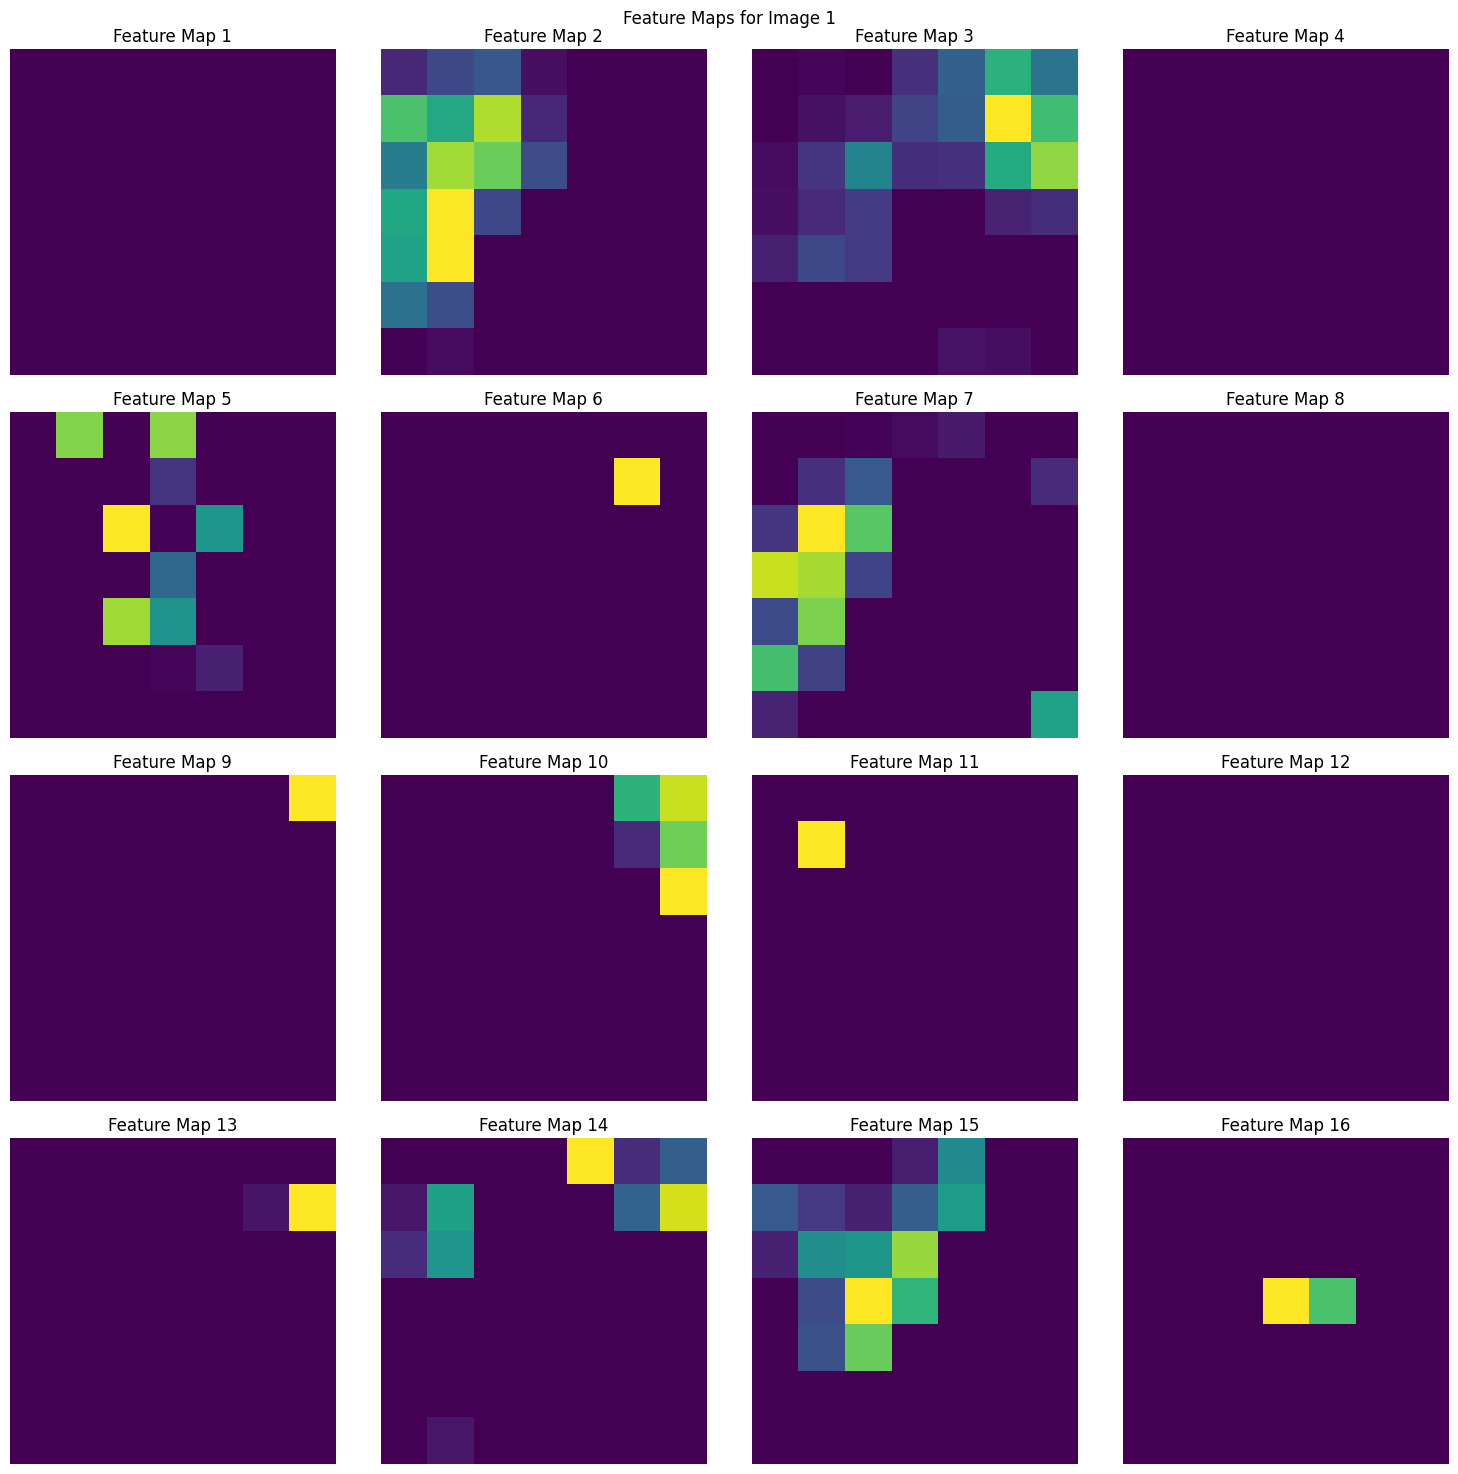

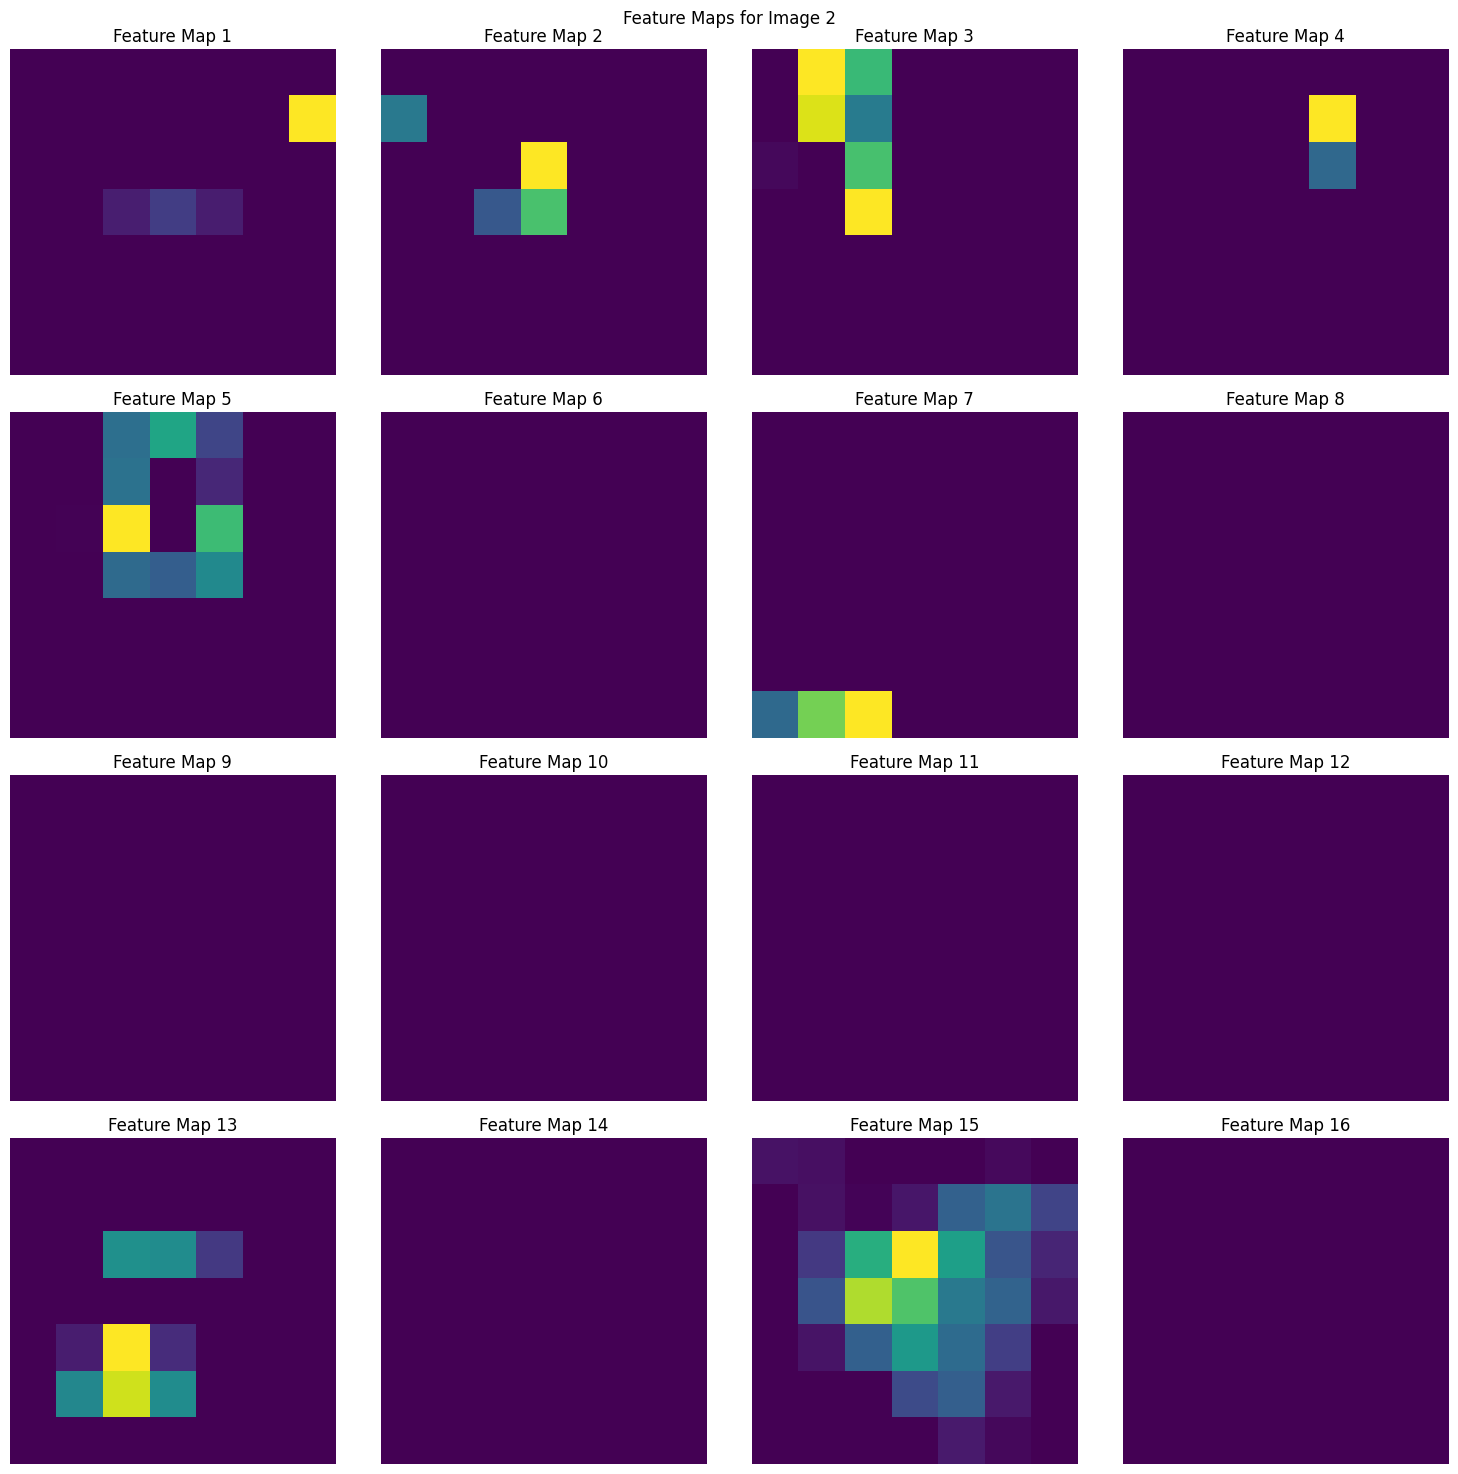

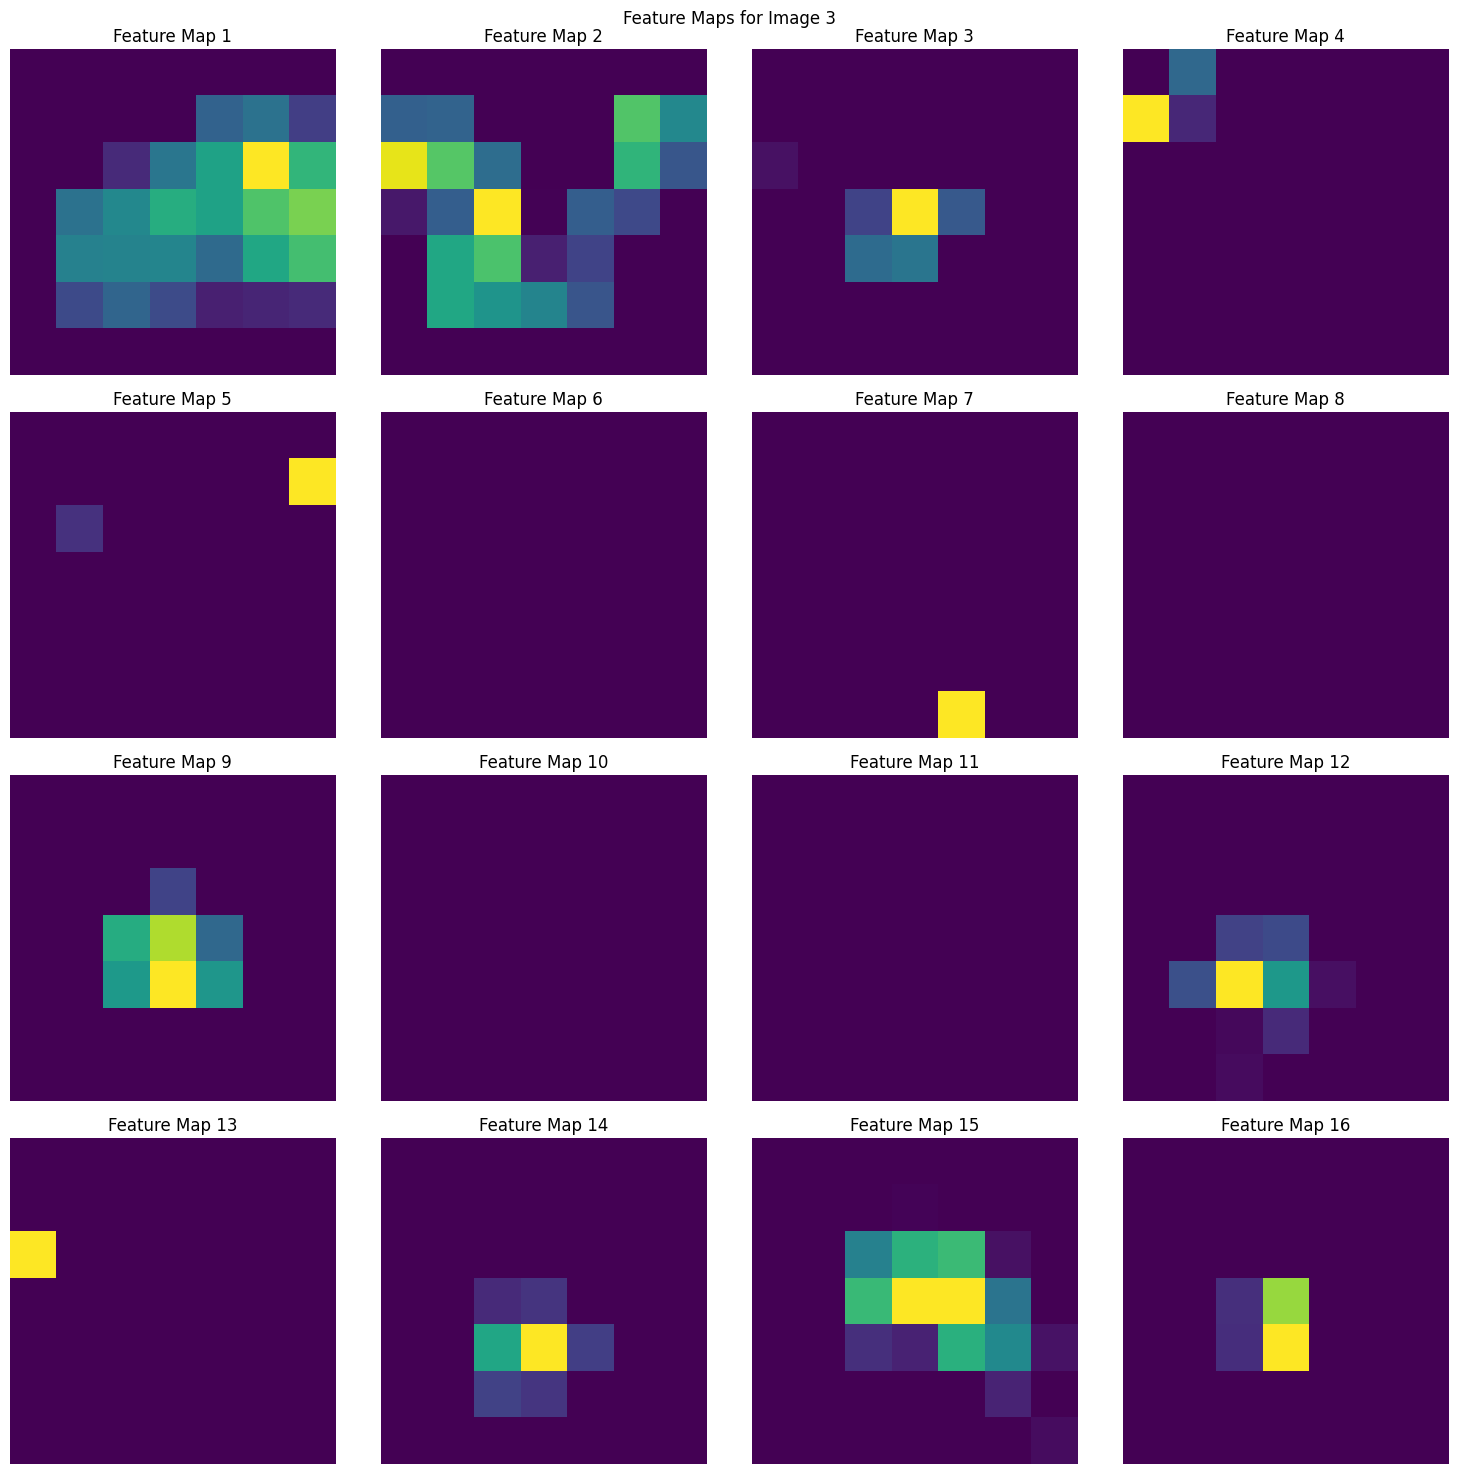

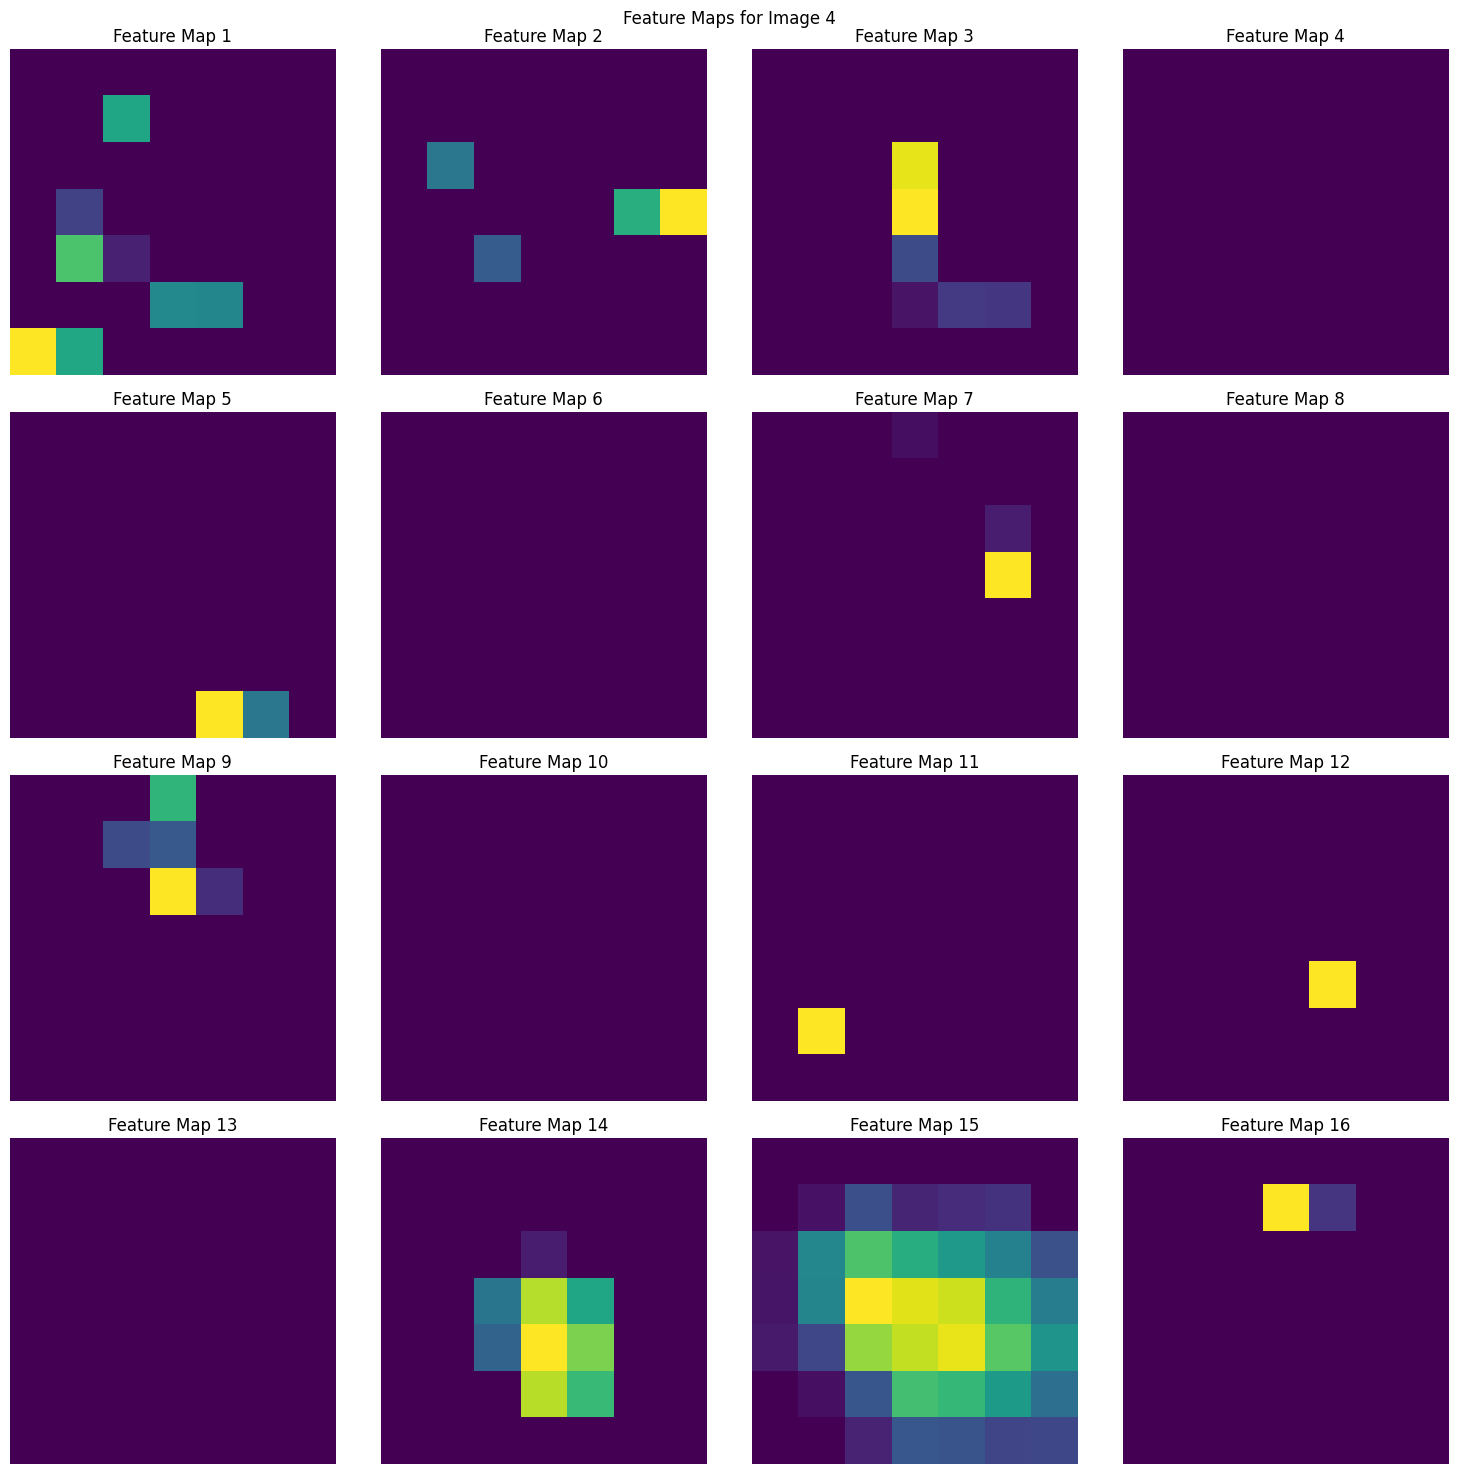

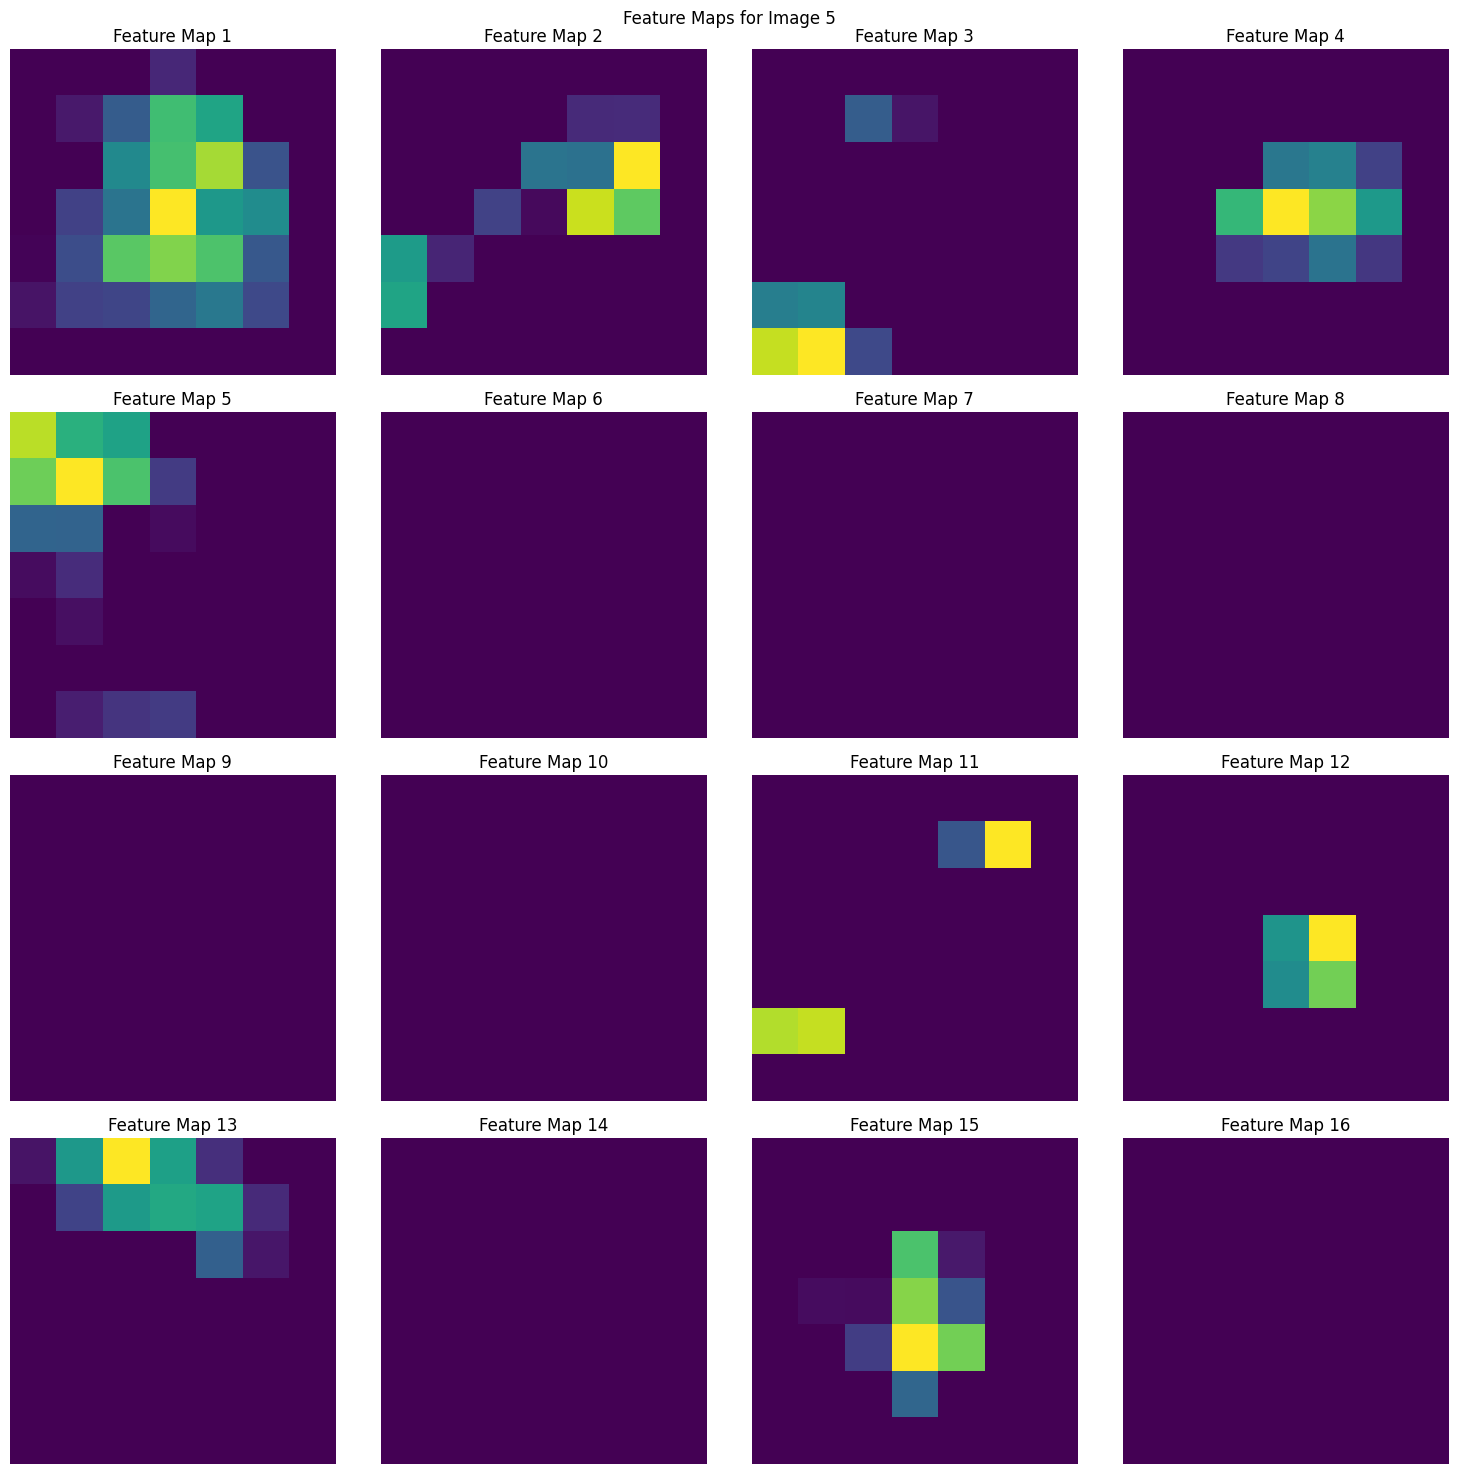

In [ ]:
def plot_feature_maps_for_image(features, image_index, title):
    # Extract the feature maps for the specific image (image_index)
    sample_feature_maps = features[image_index]

    # Handle 3D or 4D feature map cases
    if len(sample_feature_maps.shape) == 3:
        sample_feature_maps = np.expand_dims(sample_feature_maps, axis=0)  # Add batch dimension

    num_feature_maps = sample_feature_maps.shape[-1]  # Number of feature maps
    num_plots = min(num_feature_maps, 16)  # Maximum number of feature maps to plot

    # Plot each feature map
    plt.figure(figsize=(15, 15))
    for i in range(num_plots):
        plt.subplot(4, 4, i + 1)
        plt.imshow(sample_feature_maps[0, :, :, i], cmap='viridis')
        plt.title(f'Feature Map {i+1}')
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Function to visualize feature maps for a few specific images
def visualize_features_for_images(features, num_images=5):
    for i in range(min(num_images, len(features))):
        plot_feature_maps_for_image(features, i, f'Feature Maps for Image {i+1}')

# Visualize feature maps for the first 5 images in the batch
visualize_features_for_images(X_train_features, num_images=5)

In [ ]:
# Function to preprocess and extract features
def preprocess_and_extract_features(dataset, base_model):
    features = []
    labels = []
    for img_batch, label_batch in dataset:  # Iterate through batches
        preprocessed_imgs = preprocess_input(img_batch)  # Preprocess images
        feature_batch = base_model(preprocessed_imgs)    # Extract features
        features.append(feature_batch.numpy())
        labels.append(label_batch.numpy())
    return np.vstack(features), np.hstack(labels)

# Extract features for train, validation, and test datasets
X_train_features, y_train = preprocess_and_extract_features(train_data, base_model)
X_val_features, y_val = preprocess_and_extract_features(val_data, base_model)
X_test_features, y_test = preprocess_and_extract_features(test_data, base_model)

# Reshape extracted features for LSTM input
timesteps = X_train_features.shape[1]  # Height of the feature map
features = X_train_features.shape[2] * X_train_features.shape[3]  # Width * Channels
X_train = X_train_features.reshape(-1, timesteps, features)
X_val = X_val_features.reshape(-1, timesteps, features)
X_test = X_test_features.reshape(-1, timesteps, features)


In [ ]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

# LSTM model
model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(timesteps, features)),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(64, activation='tanh'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')  # Binary classification output
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # or 'categorical_crossentropy'
              metrics=['accuracy'])

In [ ]:
samples=2637
batch_size=35
new_values= samples//batch_size

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=batch_size
)

Epoch 1/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.7665 - loss: 0.5039 - val_accuracy: 0.8225 - val_loss: 0.4393
Epoch 2/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8603 - loss: 0.3050 - val_accuracy: 0.8346 - val_loss: 0.3580
Epoch 3/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8847 - loss: 0.2534 - val_accuracy: 0.8194 - val_loss: 0.3651
Epoch 4/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9065 - loss: 0.2172 - val_accuracy: 0.8483 - val_loss: 0.3703
Epoch 5/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9136 - loss: 0.1915 - val_accuracy: 0.8407 - val_loss: 0.4182
Epoch 6/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9264 - loss: 0.1689 - val_accuracy: 0.8361 - val_loss: 0.4209
Epoch 7/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9366 - loss: 0.1515 - val_accuracy: 0.7420 - val_loss: 1.1137
Epoch 8/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9349 - loss: 0.1708 - val_accuracy: 0.8209 - v

In [ ]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy:.2f}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8138 - loss: 0.7669
Validation Accuracy: 0.82


In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8609 - loss: 0.5256
Test Accuracy: 0.85


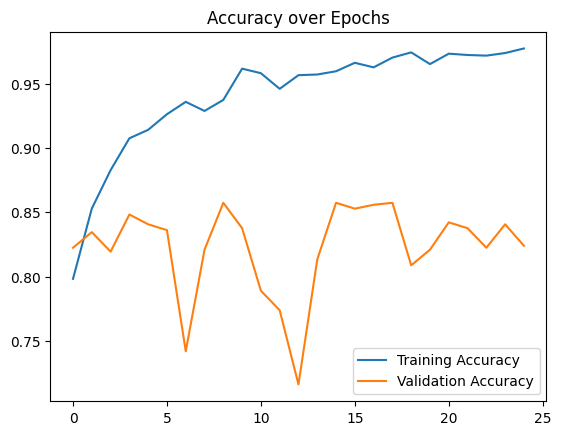

In [ ]:
# Plot training history
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

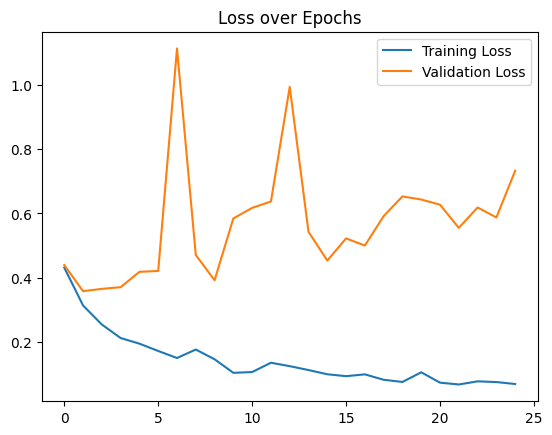

In [ ]:
# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()

In [ ]:
# Predict and display results
class_names = ['Benign', 'Malignant']
predictions = model.predict(X_test[:10])

for i, pred in enumerate(predictions):
    predicted_class = np.argmax(pred)
    true_class = y_test[i]
    print(f"True Class: {class_names[true_class]}")
    print(f"Predicted Class: {class_names[predicted_class]}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
True Class: Benign
Predicted Class: Benign

True Class: Malignant
Predicted Class: Malignant

True Class: Benign
Predicted Class: Benign

True Class: Malignant
Predicted Class: Malignant

True Class: Malignant
Predicted Class: Malignant

True Class: Benign
Predicted Class: Benign

True Class: Benign
Predicted Class: Benign

True Class: Malignant
Predicted Class: Malignant

True Class: Malignant
Predicted Class: Malignant

True Class: Malignant
Predicted Class: Malignant



In [ ]:
model.save("lstm_model.h5")

In [ ]:
# Make Predictions
class_names = ['Benign', 'Malignant']

for i in range(10):  # Display predictions for the first 5 test samples
    pred = model.predict(np.expand_dims(X_test[i], axis=0))
    predicted_class = np.argmax(pred)
    true_class = y_test[i]
    print(f"Sample {i+1}: True Class: {class_names[true_class]}")
    print(f"Predicted Class: {class_names[predicted_class]}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Sample 1: True Class: Benign
Predicted Class: Benign

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Sample 2: True Class: Malignant
Predicted Class: Malignant

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Sample 3: True Class: Benign
Predicted Class: Benign

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Sample 4: True Class: Malignant
Predicted Class: Malignant

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Sample 5: True Class: Malignant
Predicted Class: Malignant

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Sample 6: True Class: Benign
Predicted Class: Benign

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Sample 7: True Class: Benign
Predicted Class: Benign

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Sample 8: True Class: Malignant
Predicted Class: Malignant

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Sample 9: True Class: Malignant
Predicted Class: Malignant

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Sample 10: True Class: Malignant
Predicted Class: Malignant

